# Introduction

This notebook is a tutorial and overview of the cubify script and the Planet class within it. cubify will read in your IGRINS exoplanet data, extract relevant information from the FITS headers, and organize your data into cuboids ready to go for high res cross correlation analysis, with the goal of minimal effort and thinking on your part. The Planet class has a convenient method $\texttt{do_it_all}$ that will literally do everything, but I reccommend going through this tutorial and calling each individual method at least once in order to know what's happening under the hood.

# Getting started

To use cubify in either a jupyter notebook, command line script, or just in command line, you simply need to import the Planet class from cubify. Everything you need to do will be methods associated with this class.

In [1]:
from cubify import Planet

C:\Users\peter\Anaconda3\lib\site-packages\cupy\_environment.py:214: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  'CUDA path could not be detected.'


With the Planet class imported, if you every forget the order of operations from this tutorial, you can conventienly take a look at the docstring:

In [ ]:
?Planet

To initialize a Planet object, you only need two things: the name of the planet, and the path to the directory your data are in. Let's initilize a Planet object to cubify data of the ultra-hot Jupiter WASP-18 b (presented in Brogi et al. 2023).

In [2]:
wasp18 = Planet(planetname='WASP-18 b', path='../w18/emission/20210925/')

We now have the $\texttt{wasp18}$ Planet object. To go further, we need to set the following attributes to the Planet: period, T0 (transit midpoint), RV (stellar radial velocity), RA, DEC, and Tdur (transit duration). You can look up and set these attributes manually, however the Planet class has a convenient method get_params that will do this for you. get_params will query either the NASA Exoplanet Archive (NEA) or the Transiting Exoplanet Catalogue (TEPCat) to get these parameters. If you do so, having the planetname variable in a recognizable format to these services is required. Typically, this just means all caps and a space between the numbers and the letter, as "WASP-18 b" is above.

The default for get_params is to query TEPCat, and it's not required to pass any arguments through the get_params method:

In [3]:
wasp18.get_params()

Rp: 1.204 Mp: 10.52 Rstar: 1.255
Kp: 237.4679450227524 km / s


(0.941452407, 2458022.125226, 0.0, '01 37 25.03', '−45 40 40.4', 2.1814)

The stellar RV is the only parameter not listed on TEPCat, so by default the RV attribute will be set to 0 km/s. This means that the radial velocity array (discussed below) will only be the Earth barycentric radial velocity correction. A typical line-of-sight velocity calculation such as

$$ V_\mathrm{LOS}(t)  = RV(t) + K_P \sin[2 \pi \phi(t)] $$

for your planet will then be in the Sun's barycentric frame, and the $V_\mathrm{sys}$ of your planet signal will show up at the stellar RV in CCF maps, rather than at 0 km/s. If you would rather the line-of-sight velocity to be in the stellar barycentric frame (and CCF detection at $dV_\mathrm{sys} =$ 0 km/s), you can either manually set the RV attribute yourself:

In [8]:
wasp18.RV = 3.2

or pass the keyword argument get_RV=True through get_params:

In [7]:
wasp18.get_params(get_RV=True)

Rp: 1.204 Mp: 10.52 Rstar: 1.255
Kp: 237.4679450227524 km / s
Taking values from                                                               st_refname                                                              
--------------------------------------------------------------------------------------------------------------------------------------
<a refstr=HELLIER_ET_AL__2009 href=https://ui.adsabs.harvard.edu/abs/2009Natur.460.1098H/abstract target=ref> Hellier et al. 2009 </a>


(0.941452407, 2458022.125226, 3.2, '01 37 25.03', '−45 40 40.4', 2.1814)

With get_RV=True, get_params will query NEA and find the most recent stellar RV measurement. You can otherwise get everything else from NEA by setting the keyword argument source='nea'. By default this will grab the most recent, most complete set of parameters:

In [8]:
wasp18.get_params(source='nea', get_RV=True)

Taking values from <a refstr=HELLIER_ET_AL__2009 href=https://ui.adsabs.harvard.edu/abs/2009Natur.460.1098H/abstract target=ref> Hellier et al. 2009 </a>


(0.94145299, 2454221.48163, 3.2, '01h37m25.07s', '-45d40m40.06s', 2.14368)

You can opt for the most recent reference with the optional which keyword:

In [10]:
wasp18.get_params(source='nea', get_RV=True, which='most recent')

Taking values from <a refstr=EXOFOP_TESS_TOI href=https://exofop.ipac.caltech.edu/tess/view_toi.php target=ref>ExoFOP-TESS TOI</a>


(0.9414525, 2460205.353322, nan, '01h37m25.07s', '-45d40m40.06s', 2.05)

Or if you have a reference in mind, you can use the ref keyword:

In [11]:
wasp18.get_params(source='nea', get_RV=True, ref='Kokori 2023')

(0.94145242, 2458501.324483, 3.2, '01h37m25.07s', '-45d40m40.06s', nan)

And as with the RV attribute, you can fill in any missing parameters manually:

In [12]:
wasp18.Tdur = 2.14368

# Making the data cuboid

Now we're ready to read in the FITS files and organize them into a data cuboid. We will also extract the time, phase, airmass, humidity, exposure time, star-observatory radial velocity, signal-to-noise, and variance per frame. All of this is done by simply calling the cubify method:

In [4]:
wasp18.cubify()

(array([[2.48453515, 2.48455405, 2.48457294, ..., 2.51854823, 2.51856228,
         2.51857633],
        [2.45045542, 2.45047397, 2.45049252, ..., 2.4840926 , 2.48410673,
         2.48412086],
        [2.41731458, 2.41733283, 2.41735107, ..., 2.45057741, 2.45059157,
         2.45060573],
        ...,
        [1.45200832, 1.45201954, 1.45203076, ..., 1.47219583, 1.4722047 ,
         1.47221356],
        [1.44077094, 1.44078206, 1.44079317, ..., 1.46077963, 1.46078841,
         1.46079719],
        [1.42971765, 1.42972865, 1.42973965, ..., 1.44954913, 1.44955783,
         1.44956652]]),
 array([[[            nan, -2.78345013e+01, -5.54278708e+00, ...,
                      nan,             nan,             nan],
         [            nan, -2.29171753e+00, -2.71772104e-03, ...,
                      nan,             nan,             nan],
         [            nan, -8.00033188e+00,  1.14242048e+01, ...,
                      nan,             nan,             nan],
         ...,
         [ 

The Planet object how has a bunch of more attributes - all new arrays of the quantities I just listed, and we even got a warning message that one of our frames was taken in eclipse, so we might want to discard it.

The most important new arrays are probably rvel_arr and ph_arr. rvel_arr is the combination of the stellar RV attribute and the Observatories barycentric radial velocity correction. The phase array is calculated with the period and T0 attributes previously fetched by the get_params method and after converting the time of each exposure to BJD, which is why we needed the stellar RA and DEC.

To take a look at our new data cuboid, we can use the plot method, which plots one echelle order's spectra stacked in time:

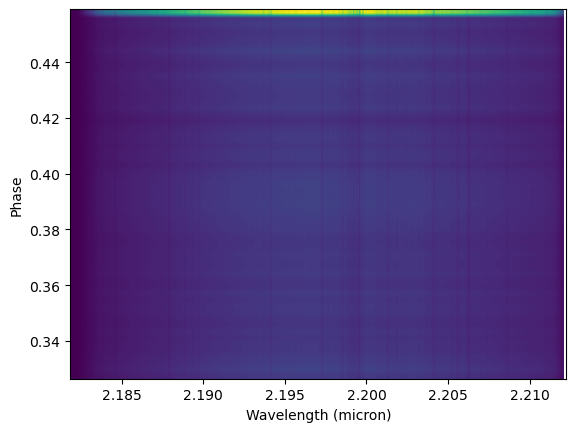

In [14]:
wasp18.plot(order = 10)

Looks like something funky happened that last frame! That one was during eclipse anyway, so we can discard it with the trim method.

In [5]:
wasp18.trim()

Number frames to discard from beginning:0
Number of frames to discard from end:1
N frames: 57


trim also has an optional keyword argument transit_only, which when set to True only keeps frames during transit. Because this is a thermal emission data set, let's leave that alone.

Let's also take a look at the median signal-to-noise in time of our data:

C:\Users\peter\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


Median H: 185.1289825439453
Median K: 168.99011993408203


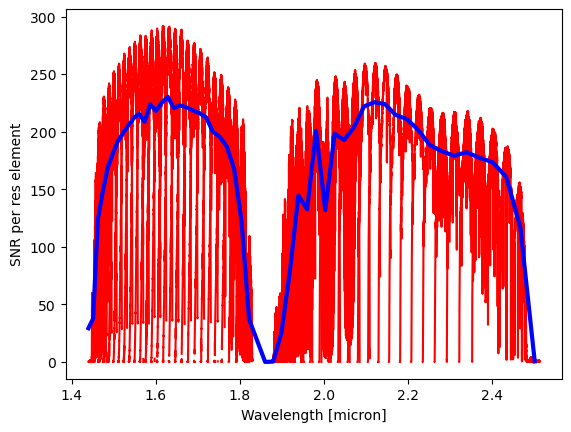

array([[       nan, 0.        , 0.19044673, ...,        nan,        nan,
               nan],
       [       nan, 2.01795611,        nan, ..., 0.        , 0.        ,
        0.        ],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan, 0.21312334, 0.36546424, ...,        nan, 0.        ,
               nan],
       [       nan, 0.19868054, 0.22562944, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ]])

In [5]:
wasp18.plot_snr()

Before we do anything else with the data, we should apply a secondary wavelength solution. The IGRINS wavelength solution can drift by fractions of a pixel over the course of a several-hour observation. This solution is made from comparison to a telluric model by the PLP, typically at the end of the observation, so the last frame usually has a pretty accurate solution. We can then compare the other frames to the last one and fit a polynomial wavelength adjustment:

$$ \lambda' = a + (\lambda - \lambda_0) \times b  $$

where $a$ is a simple shift and $b$ is multiplicative stretching term centered at $\lambda_0$.

The align method fits for this and then interpolates the data onto the new wavelength solution.

In [6]:
wasp18.align()

(array([[2.45230079, 2.45231914, 2.45233749, ..., 2.48266621, 2.4826806 ,
         2.48269498],
        [2.41913119, 2.41914927, 2.41916736, ..., 2.44915165, 2.449166  ,
         2.44918036],
        [2.38686577, 2.38688361, 2.38690144, ..., 2.41654427, 2.41655855,
         2.41657284],
        ...,
        [1.47618875, 1.47620002, 1.47621128, ..., 1.49469725, 1.49470636,
         1.49471546],
        [1.46455892, 1.46457009, 1.46458124, ..., 1.48290404, 1.48291306,
         1.48292207],
        [1.45312233, 1.45313339, 1.45314445, ..., 1.47130585, 1.47131479,
         1.47132372]]),
 array([[[1.68305360e+03, 1.70253561e+03, 1.71918879e+03, ...,
          1.91950342e+02, 1.67384425e+02, 1.41566019e+02],
         [1.95888674e+03, 1.94925822e+03, 1.96137528e+03, ...,
          1.37748797e+02, 1.58943423e+02, 1.44407595e+02],
         [1.80157015e+03, 1.80679600e+03, 1.81775928e+03, ...,
          1.93954172e+02, 1.66562489e+02, 1.52474776e+02],
         ...,
         [1.66332347e+03, 1.6

There are a couple of other things going on in the align method. We're also throwing out some orders that have low SNR. The default is to throw out orders with a median SNR < 50, but you can change this with the min_snr keyword:

In [21]:
wasp18.align(min_snr=100)

(array([[2.45230079, 2.45231914, 2.45233749, ..., 2.48266621, 2.4826806 ,
         2.48269498],
        [2.41913119, 2.41914927, 2.41916736, ..., 2.44915165, 2.449166  ,
         2.44918036],
        [2.38686577, 2.38688361, 2.38690144, ..., 2.41654427, 2.41655855,
         2.41657284],
        ...,
        [1.47618875, 1.47620002, 1.47621128, ..., 1.49469725, 1.49470636,
         1.49471546],
        [1.46455892, 1.46457009, 1.46458124, ..., 1.48290404, 1.48291306,
         1.48292207],
        [1.45312233, 1.45313339, 1.45314445, ..., 1.47130585, 1.47131479,
         1.47132372]]),
 array([[[1.68305360e+03, 1.70253561e+03, 1.71918879e+03, ...,
          1.91950342e+02, 1.67384425e+02, 1.41566019e+02],
         [1.95888674e+03, 1.94925822e+03, 1.96137528e+03, ...,
          1.37748797e+02, 1.58943423e+02, 1.44407595e+02],
         [1.80157015e+03, 1.80679600e+03, 1.81775928e+03, ...,
          1.93954172e+02, 1.66562489e+02, 1.52474776e+02],
         ...,
         [1.66332347e+03, 1.6

If you set whichorders=None, align will keep a hard coded selection of orders that have don't have too much telluric contamination. Align can also normalize each frame by setting normed=True, or align to the first frame by setting which='first'.

align can also interpolate over nan's and negative values by setting interpolation=True. This will create a mask of where the nan's were originally so you can add them back in later.

# Detrending

We're now ready to detrend our data! You have a choice between SysRem or SVD, and each has their own method:

In [22]:
wasp18.do_sysrem(niter=5)

(array([[[-2.42967519e-03,  5.73328229e-03,  8.43463360e-03, ...,
           2.28037047e-02,  1.25002490e-02,  3.45551457e-03],
         [ 2.70771338e-03,  1.18704792e-03, -3.81941783e-04, ...,
          -3.42237560e-03,  3.14629527e-03, -8.55764628e-04],
         [ 4.08061559e-03,  6.59630732e-03,  6.86592409e-03, ...,
           2.04560422e-02,  9.56525102e-03,  5.21901479e-03],
         ...,
         [-1.53074329e-02, -6.76031162e-03, -1.80808832e-03, ...,
           5.04254281e-03,  4.03189444e-03,  3.95325051e-03],
         [ 8.32309938e-03,  5.69607357e-03,  1.30691167e-02, ...,
           2.13335465e-02,  2.32494775e-02,  2.89346172e-02],
         [-7.30523768e-03, -8.67872711e-04, -1.67748034e-04, ...,
           3.90272182e-02,  2.71617552e-02,  3.93417449e-02]],
 
        [[-8.99215690e-03, -7.93238530e-03, -7.27389242e-03, ...,
          -6.27464840e-03,  2.29237562e-03,  2.05527863e-02],
         [ 9.32576061e-03,  9.19680854e-03,  3.03318927e-03, ...,
           1.22201650

In [7]:
wasp18.do_svd(NPC=5)

(array([[[-2.68963399e+01, -5.57787831e+00,  4.89360143e+00, ...,
           3.88491266e+01,  1.57424956e+01, -1.48199067e+01],
         [-5.50252073e+00, -1.00923836e+01, -7.01545845e+00, ...,
          -1.74024528e+01,  2.44022587e+00, -1.22167484e+01],
         [-1.04359194e+01, -2.60618799e+00,  2.12192978e+00, ...,
           2.89388343e+01,  4.01246645e+00, -1.65625856e+01],
         ...,
         [-5.18128201e+01, -2.75404418e+01, -1.74476024e+01, ...,
          -1.17211903e+01, -9.78689486e+00, -7.48760344e+00],
         [ 1.33895505e+01,  4.49564069e+00,  2.83567049e+01, ...,
           4.56105384e+00,  1.86277654e+01,  2.49815709e+01],
         [-3.30516479e+00, -5.10219195e-01, -3.37762559e+00, ...,
          -2.62188910e+00, -1.88989524e+00, -5.64345990e-01]],
 
        [[ 1.39175349e+01, -8.61736972e+00, -1.12690287e+01, ...,
          -6.36608150e+01, -1.90138784e+01,  4.71054842e+01],
         [ 7.00754654e+01,  5.24144616e+01,  2.27808391e+01, ...,
           1.46946509

If you do SVD, you can make a scree plot to get an idea of the variance projected onto each component:

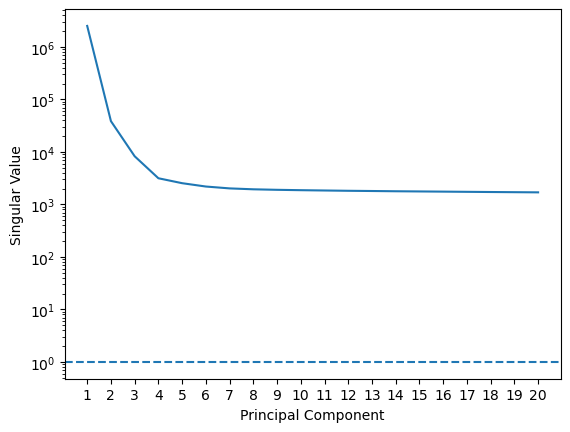

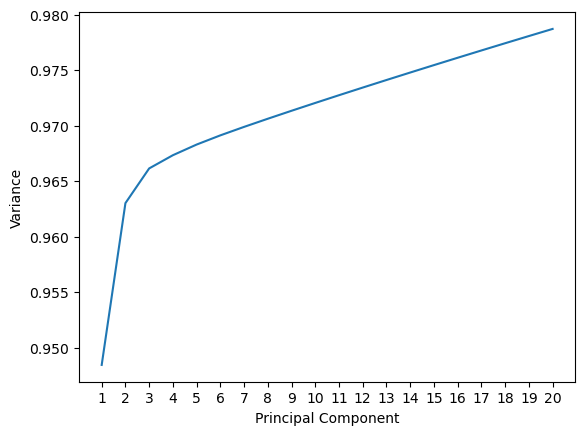

In [8]:
wasp18.plot_scree()

After either sysrem or svd, the Planet object will have two new attributes - a matrix of the first few components removed, and another with only the first few for model filtering. We're almost ready to work with our data! As a final step, if you would like to use per-pixel uncertainties, you can get these with the get_error method. There are three options here, "PLP", "gibson", and "boucher". "PLP" will scale the raw variance as output by the PLP down to match the variance of the residuals such that the reduced chi-square of the detrending process is 1. "gibson" will do the same but with the raw spectrum (see Gibson et al. 2020), and "boucher" will use the variance of each channel in time (see Boucher et al. 2021).

In [10]:
wasp18.get_error(method="PLP")

C:\Users\peter\Documents\science\HRCCS\Data\cubify\cubify.py:836: RuntimeWarning: divide by zero encountered in true_divide
  lnlike = -0.5 * np.sum(   R**2 / Var1  ) - np.sum(np.log(  np.sqrt(Var1)  ))
C:\Users\peter\Documents\science\HRCCS\Data\cubify\cubify.py:836: RuntimeWarning: divide by zero encountered in log
  lnlike = -0.5 * np.sum(   R**2 / Var1  ) - np.sum(np.log(  np.sqrt(Var1)  ))
C:\Users\peter\Documents\science\HRCCS\Data\cubify\cubify.py:836: RuntimeWarning: invalid value encountered in double_scalars
  lnlike = -0.5 * np.sum(   R**2 / Var1  ) - np.sum(np.log(  np.sqrt(Var1)  ))


array([[[24.8736    , 24.9747782 , 24.98059633, ..., 14.86139596,
         14.35200387, 14.59986614],
        [26.10054081, 25.96799355, 26.09662246, ..., 14.1654736 ,
         14.16093184, 14.09489906],
        [25.34941206, 25.47365277, 25.38339722, ..., 15.7464189 ,
         15.00729859, 14.75830984],
        ...,
        [34.0105377 , 34.195997  , 34.23899943, ..., 22.41442603,
         22.57679224, 22.78157686],
        [22.98368543, 22.95119674, 22.84285346, ..., 13.83943386,
         14.07006923, 14.05160033],
        [ 4.14741961,  4.16381409,  4.16010912, ...,  3.12409287,
          3.11735739,  3.11857663]],

       [[17.88538479, 16.53865921, 15.48889611, ..., 28.82406862,
         28.98868065, 29.30393992],
        [17.7830188 , 16.4890765 , 15.19545803, ..., 29.52117924,
         29.71358054, 29.76236899],
        [16.12284817, 14.86769683, 13.9849773 , ..., 27.34018348,
         27.22921499, 27.15929839],
        ...,
        [26.79225885, 24.9975011 , 24.57910341, ..., 4

# Saving

Saving everything is easy - just use the save method! It takes as an optional keyword a path to directory you want everything to be saved, but by default everything will save to the same directory the FITS files were in.

In [ ]:
wasp18.save()

# Doing it all

Fortunately you don't have to run all of these methods in sequence. the do_it_all method does... it all! You just have to set some keyword args, or just trust the defaults

In [ ]:
wasp18.do_it_all()

The cubify script is always in development! If you have any issues, questions, or sugges